In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. CNNs can be very slow without a GPU.


In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

## conv filters

### load some images

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])

In [8]:
type(china), china.shape, flower.shape, china[0, 0, :]

(numpy.ndarray,
 (427, 640, 3),
 (427, 640, 3),
 array([0.68235294, 0.78823529, 0.90588235]))

In [9]:
batch_size, height, width, channels = images.shape

In [10]:
batch_size, height, width, channels

(2, 427, 640, 3)

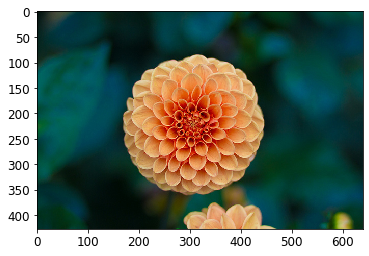

In [13]:
plt.imshow(flower);

### create filters

In [11]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

In [14]:
filters.shape

(7, 7, 3, 2)

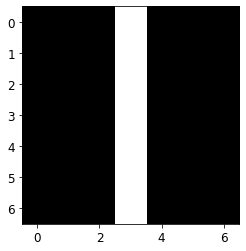

In [16]:
plt.imshow(filters[:, :, :, 0]);

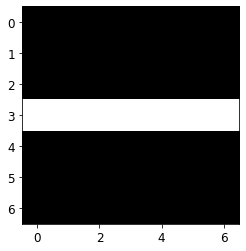

In [17]:
plt.imshow(filters[:, :, :, 1]);

### apply filters

In [18]:
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

In [19]:
outputs.shape

TensorShape([2, 427, 640, 2])

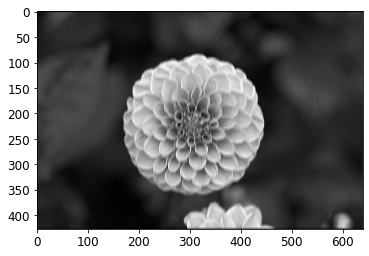

In [22]:
plt.imshow(outputs[1, :, :, 0], cmap='gray');

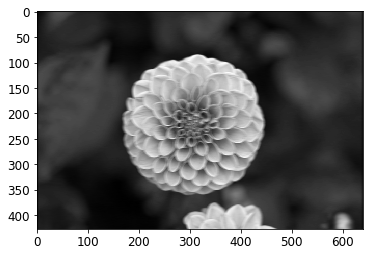

In [23]:
plt.imshow(outputs[1, :, :, 1], cmap='gray');

Can we reproduce `tf.nn.conv2d`? Let's do this for the simple case of `valid` padding. Looks like we got correct results.

In [24]:
outputs_valid = tf.nn.conv2d(images, filters, strides=1, padding="VALID")

In [25]:
outputs_valid.shape

TensorShape([2, 421, 634, 2])

In [31]:
# 1 stands for flower
# 0 stands for filter 0
outputs_valid[1, :3, :3, 0].numpy()

array([[1.15294118, 1.16078431, 1.22352941],
       [1.16862745, 1.18039216, 1.24313725],
       [1.18431373, 1.20392157, 1.25882353]])

In [35]:
np.sum(flower[:7, :7, :] * filters[..., 0])

1.1529411764705881

In [37]:
np.sum(flower[:7, 1:8, :] * filters[..., 0])

1.16078431372549

In [38]:
np.sum(flower[:7, 2:9, :] * filters[..., 0])

1.2235294117647058

### visualize results

Let's visualize results of applying these filters.

In [40]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


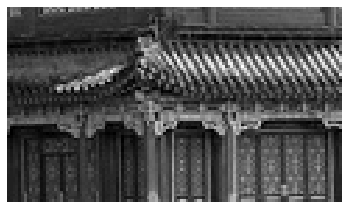

Saving figure china_vertical


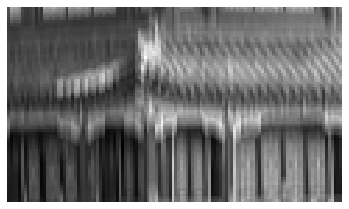

Saving figure china_horizontal


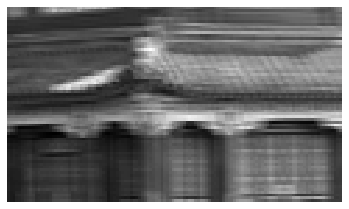

In [41]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

## max pooling

In [42]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [43]:
cropped_images = np.array([crop(image) for image in images])
output = max_pool(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [44]:
cropped_images.shape

(2, 70, 120, 3)

In [45]:
output.shape

TensorShape([2, 35, 60, 3])

In [51]:
cropped_images[0, :4, :4, 0]

array([[0.26666667, 0.42745098, 0.39607843, 0.38823529],
       [0.29019608, 0.46666667, 0.38431373, 0.42352941],
       [0.24313725, 0.49803922, 0.43921569, 0.45098039],
       [0.23921569, 0.48235294, 0.35686275, 0.34509804]])

In [50]:
output[0, :2, :2, 0].numpy()

array([[0.46666667, 0.42352942],
       [0.49803922, 0.4509804 ]], dtype=float32)

## global average pooling

>This means that it just outputs a single number per feature map and per instance. Although this is of course extremely destructive (most of the information in the feature map is lost), it can be useful as the output layer, as we will see later in this chapter.

In [52]:
global_avg_pool = keras.layers.GlobalAvgPool2D()

In [53]:
output = global_avg_pool(cropped_images)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [54]:
cropped_images.shape

(2, 70, 120, 3)

In [55]:
output.shape

TensorShape([2, 3])

In [57]:
output.numpy()

array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)

In [59]:
np.mean(cropped_images[0, :, :, 0])

0.2788776844070962